In [45]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder

In [46]:
# Read in the cleaned data from the previous notebook
team_data = pd.read_csv('BasketballData.csv').drop('Unnamed: 0', axis=1)
team_data = team_data[team_data.TeamID.notnull()]

In [47]:
team_data[team_data.Season==2009].head(3)

,Season,DayNum,TeamID,Win,Opp_TeamID,FG_rate,FT_rate,FG3_rate,ORB,DRB,...,Opp_FG_rate,Opp_FT_rate,Opp_FG3_rate,Opp_ORB,Opp_DRB,Opp_STL,Opp_BLK,Opp_AST,Opp_PF,Opp_Score_Diff
0,2009,7.0,1181.0,1.0,1342,0.439811,0.711419,0.345149,13.403704,24.340741,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
1,2009,8.0,1222.0,1.0,1342,0.410627,0.780318,0.350825,12.318182,23.901515,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05
2,2009,25.0,1155.0,1.0,1342,0.453876,0.592604,0.352820,15.828502,22.785024,...,0.391575,0.651869,0.349738,9.34,19.6,6.68,1.41,11.0,16.65,12.05


### First I will look at the correlation between the features by constructing a heatmap

In [48]:
plot_data = team_data.drop(['DayNum','TeamID','Opp_TeamID','Win','Season'], axis=1)

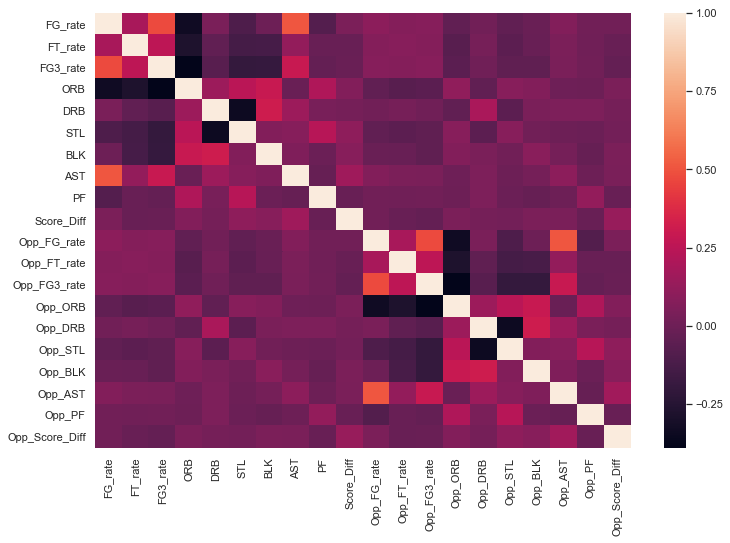

In [49]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(color_codes=True)
r2 = plot_data.corr()
sns.heatmap(r2)
plt.savefig('CorrelationHeatmap.png')
plt.show()

### None of the features appear to be strongly correlated with each other. However, there appears to be a slight correlation between field goal rate and 3 point rate, and field goal rate and assists.

In [50]:
# Read in the tournament data
tour_data = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
tour_data = tour_data[tour_data.Season>2007]
tour_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1456,2008,134,1291,69,1164,60,N,0
1457,2008,136,1181,71,1125,70,N,0
1458,2008,136,1242,85,1340,61,N,0
1459,2008,136,1243,80,1425,67,N,0
1460,2008,136,1266,74,1246,66,N,0


In [51]:
# Fill null values with the column mean
data = team_data.apply(lambda x: x.fillna(x.mean()), axis=0)

In [52]:
# Create a column indicating whether the team was in the tournament the previous season
prev_trn = []

for i in data.index:
    year = data.Season[i]
    trn_df = tour_data[tour_data.Season==year-1]
    
    trn_list = [trn_df.WTeamID[k] for k in trn_df.index] + [trn_df.LTeamID[k] for k in trn_df.index]
    
    if data.TeamID[i] in trn_list:
        prev_trn.append(1)
    elif data.TeamID[i] not in trn_list:
        prev_trn.append(0)


data['Prev_Tourn'] = prev_trn

In [54]:
# Read in the team rankings data
rankings = pd.read_csv('TeamRankings.csv').drop('Unnamed: 0', axis=1)
rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,1,Villanova,5,1,5,9,51,71,23,17,14,47,19,6,13,50,59,50,75,72
1,2,Duke,9,12,2,6,4,12,2,1,6,5,11,2,3,1,6,1,1,2
2,3,Purdue,15,9,34,71,64,24,8,13,18,31,27,145,87,51,22,67,28,24


In [55]:
# Read in the file with the team names and IDs so that the correct IDs can be added to the rankings data
team_id_pairs = pd.read_csv('Team_id_pairs.csv').drop('Unnamed: 0', axis=1)

team_id_dict = {}

for i in team_id_pairs.index:
    name = team_id_pairs.TeamName[i]
    team_id = team_id_pairs.TeamID[i]
    team_id_dict[name] = team_id

In [56]:
# Create a column with the team IDs in the rankings data
t_id_list = []

for i in rankings.index:
    name = rankings.School[i]
    if name in team_id_dict:
        team_id = int(team_id_dict[name])
        t_id_list.append(team_id)
    elif name not in team_id_dict:
        t_id_list.append(0)
    
rankings['TeamID'] = t_id_list

rankings.head(3)

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,...,2008,2007,2006,2005,2004,2003,2002,2001,2000,TeamID
0,1,Villanova,5,1,5,9,51,71,23,17,...,47,19,6,13,50,59,50,75,72,1437
1,2,Duke,9,12,2,6,4,12,2,1,...,5,11,2,3,1,6,1,1,2,1181
2,3,Purdue,15,9,34,71,64,24,8,13,...,31,27,145,87,51,22,67,28,24,1345


In [57]:
# Create a column in the main dataframe with the previous year's ranking
prev_rank = []

for i in data.index:
    prev_year = str(data.Season[i]-1)
    team = data.TeamID[i]
    rank_year = list(rankings.TeamID)
    
    if team in rank_year:
        k = rankings[rankings.TeamID==team].index[0]
        rank = rankings[prev_year][k]
        prev_rank.append(int(rank))
    elif team not in rank_year:
        prev_rank.append(np.nan)
        
data['Prev_Rank'] = prev_rank

In [58]:
data.columns

Index(['Season', 'DayNum', 'TeamID', 'Win', 'Opp_TeamID', 'FG_rate', 'FT_rate',
       'FG3_rate', 'ORB', 'DRB', 'STL', 'BLK', 'AST', 'PF', 'Score_Diff',
       'Opp_FG_rate', 'Opp_FT_rate', 'Opp_FG3_rate', 'Opp_ORB', 'Opp_DRB',
       'Opp_STL', 'Opp_BLK', 'Opp_AST', 'Opp_PF', 'Opp_Score_Diff',
       'Prev_Tourn', 'Prev_Rank'],
      dtype='object')

### Now I will construct a few scatterplots to look at the correlation between some of the features

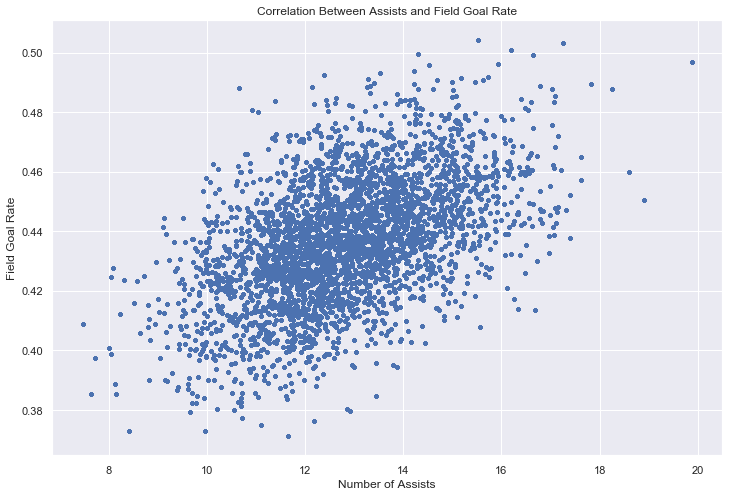

In [59]:
# Plot the number of assists vs field goal rate
fg = data.FG_rate
ast = data.AST
plt.plot(ast, fg, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Field Goal Rate')
plt.title('Correlation Between Assists and Field Goal Rate')
plt.savefig('Assists_FieldGoals_plot.png')
plt.show()

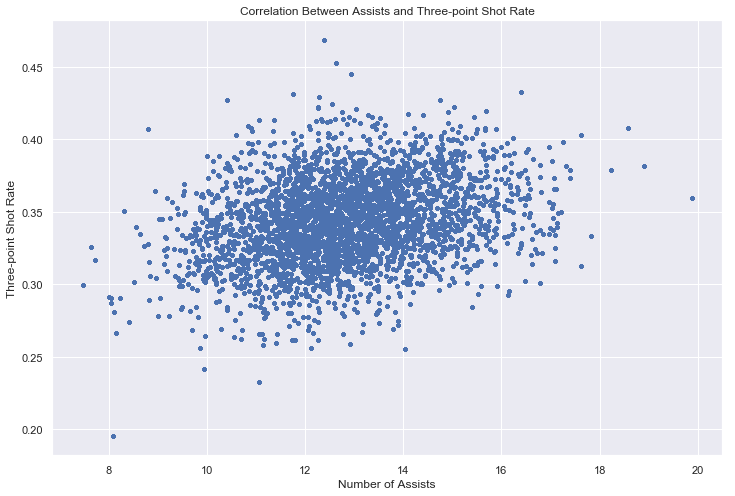

In [60]:
# Plot the number of assists vs. three point rate
fg3 = data.FG3_rate
ast = data.AST
plt.plot(ast, fg3, marker='.', linestyle='none')
plt.xlabel('Number of Assists')
plt.ylabel('Three-point Shot Rate')
plt.title('Correlation Between Assists and Three-point Shot Rate')
plt.savefig('Assists_3pt_plot.png')
plt.show()

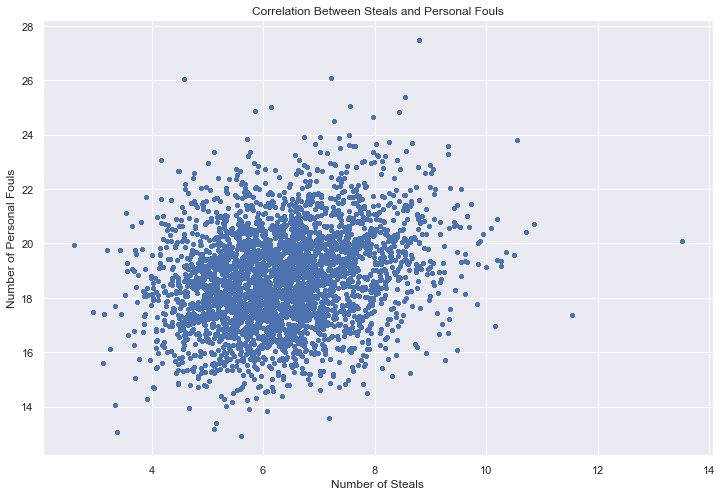

In [61]:
# Plot the number of steal vs. number of personal fouls
stl = data.STL
pf = data.PF
plt.plot(stl, pf, marker='.', linestyle='none')
plt.xlabel('Number of Steals')
plt.ylabel('Number of Personal Fouls')
plt.title('Correlation Between Steals and Personal Fouls')
plt.savefig('Steals_Fouls_plot.png')
plt.show()

### Create boxplots for the field goal rates for each season to see if it has changed over time

In [62]:
fg_rates = []
for s in data.Season.unique():
    sr = list(data[data.Season==s].FG_rate)
    fg_rates.append(sr)

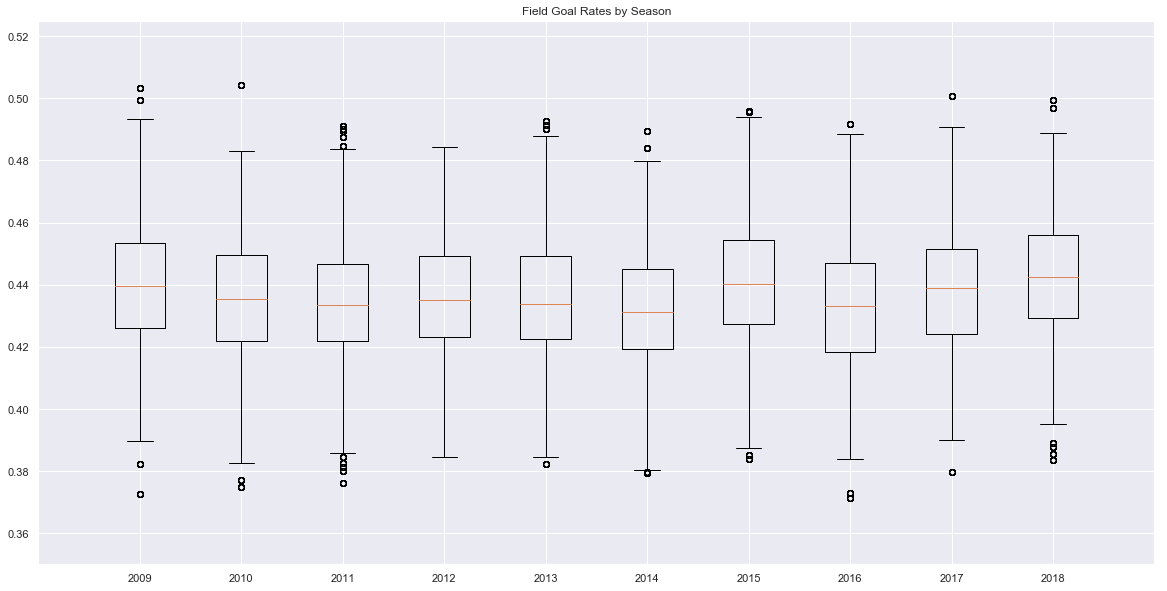

In [63]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title('Field Goal Rates by Season')
_= plt.boxplot(fg_rates, labels = data.Season.unique())
plt.axis([0, 11, 0.35, 0.525])
plt.show()

### There does not appear to be any significant change in the field goal rates over the past 10 years